In [1]:
import queue
import numpy as np
from typing import List, Tuple
import math
import datetime
import pandas as pd
import itertools
from random_gen import RandomNumberGenerator2
import time
from multiprocessing import Pool, cpu_count
import random
import matplotlib.pyplot as plt



seed = 42
np.random.seed(seed)
random.seed(seed)



In [ ]:
class AlgorithmSA:
    def __init__(self, 
                 iterations:int,
                 factors:List[Tuple]
                 ):
        self.iterations = iterations
        self.factors = factors
        
        
    def eval_end_times(self, p) -> List:
        C = []
        length = p[0].shape[0]
        for i in range(length):
            if i == 0:
                C.append(p[0][i] + p[1][i] + p[2][i])
            else:
                tmp = C[i-1] + p[0][i] + p[1][i] + p[2][i]
                C.append(tmp)
        return C
        
        
    def eval_criterion(self, p, d) -> Tuple:
        kry_3 = None
        kry_4 = 0
        kry_5 = None
        C = self.eval_end_times(p)
        length = p[0].shape[0]
        for i in range(length):
            diff = C[i] - d[i]
            
            if kry_5 is None or kry_5 < diff:
                kry_5 = diff
            
            diff_pos = max(diff, 0)
            if kry_3 is None or kry_3 < diff_pos:
                kry_3 = diff_pos
            kry_4 += diff_pos                
        return [kry_3, kry_4, kry_5]        
        
    def get_initial(self, p, d):
        length = len(p[0])
        new_order = np.random.permutation(length)
        p = [p[0][new_order], p[1][new_order], p[2][new_order]]
        d = d[new_order]
        return p, d
    
    def get_neighbor(self, p, d):
        neighbor = p.copy()
        i, j = random.sample(range(p[0].shape[0]), 2)
        neighbor[0][i], neighbor[0][j] = neighbor[0][j], neighbor[0][i]
        neighbor[1][i], neighbor[1][j] = neighbor[1][j], neighbor[1][i]
        neighbor[2][i], neighbor[2][j] = neighbor[2][j], neighbor[2][i]
        
        neighbor_d = d.copy()
        neighbor_d[i], neighbor_d[j] = neighbor_d[j], neighbor_d[i]
        return neighbor, neighbor_d
                        
    def dominates(self, a, b):
        return (a[0] <= b[0] and a[1] <= b[1]) and (a[0] < b[0] or a[1] < b[1])
    
    def calc_prob(self):
        return 0.1
    
    def fitness(self, x) -> float:
        return self.factors[0] * x[0] + self.factors[1] * x[1] + self.factors[2] * x[2]
        
    def run(self, p, d):
        it = 0
        p, d = self.get_initial(p, d)
        x = self.eval_criterion(p, d)
        fitness = self.fitness(x)
                
        while it < self.iterations:
            p_neigh, d_neigh = self.get_neighbor(p, d)
            x_prim = self.eval_criterion(p_neigh, d_neigh)
            fitness_prim = self.fitness(x_prim)

            if fitness_prim < fitness:
                p, d = p_neigh, d_neigh
                x, fitness = x_prim, fitness_prim
            else:
                pass

        
        return F, P
            
            
        
random_gen = RandomNumberGenerator2(seedVaule=seed) # type: ignore
p, d = random_gen.generate_input(100)

algorithm = AlgorithmSA(iterations=1000)
F, P = algorithm.run(p, d)
print("Pareto Front:")
print(F)
print("All Points:")
print(P)

TypeError: AlgorithmSA.__init__() missing 1 required positional argument: 'factors'

# PARETO

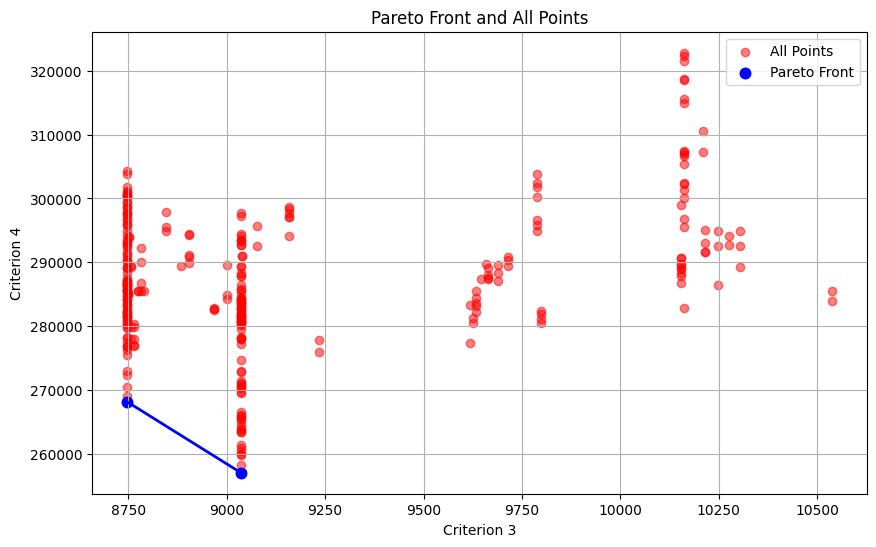

In [ ]:
#plot pareto

plt.figure(figsize=(10, 6))
P_arr = np.array(P)
plt.scatter(P_arr[:, 0], P_arr[:, 1], label='All Points', color='red', alpha=0.5)

# Sort Pareto points by x-coordinate (Criterion 1)
sorted_indices = np.argsort(F[:, 0])
sorted_F = F[sorted_indices]

# Plot scattered Pareto points
plt.scatter(sorted_F[:, 0], sorted_F[:, 1], label='Pareto Front', color='blue', 
            s=50, edgecolor='blue', linewidth=1.5, marker='o')

# Connect Pareto points with a line
plt.plot(sorted_F[:, 0], sorted_F[:, 1], color='blue', linestyle='-', linewidth=2)

plt.xlabel('Criterion 3')
plt.ylabel('Criterion 4')
plt.title('Pareto Front and All Points')
plt.legend()
plt.grid(True)
plt.show()